# Τεχνητή Νοημοσύνη και Εφαρμογές στο Διαδίκτυο των Πραγμάτων - 2η Εργασία

Στην εργασία αυτή θα ασχοληθούμε με την ανάπτυξη μοντέλων Συνελικτικών Νευρωνικών ∆ικτύων
(ΣΝ∆) για την κατηγοριοποίηση (classification) εικόνων. Θα χρησιμοποιήσουμε το σύνολο δεδομένωn Food11 Image Classification Dataset, το οποίο περιέχει εικόνες από φαγητά. Στόχος είναι η κατηγοριοποίηση των
εικόνων σε 11 κλάσεις (labels) ανάλογα με το φαγητό που απεικονίζεται. Συγκεκριμένα, το dataset είναι μια
μικρότερη εκδοχή του Food-101 και περιέχει 11000 εικόνες με 11 διαφορετικά είδη φαγητού.

## Φόρτωση Δεδομένων

### 2.1 Βήμα 1 - ∆ημιουργία PyTorch Dataset και Dataloader

In [28]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchtext
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils import classes, smooth
import numpy as np
import json
import os

Στο παρακάτω code block, φορτώνονται τα δεδομένα και εισάγεται το dictionairy `classes` απο το `utils.py` αρχείο που περιέχει τις κλάσεις των δεδομένων συνοδευόμενες απο ένα σχετικό μοναδικό αριθμό (ID) το οποίο χρησιμεύει για τη δημιουργία των κλάσεων των νευρωνικών δικτύων

In [37]:
train_data = pd.read_csv("train.csv")

test_data = pd.read_csv("test.csv")

print("classes:", json.dumps(classes, indent=4))

classes: {
    "apple_pie": 0,
    "cheesecake": 1,
    "chicken_curry": 2,
    "french_fries": 3,
    "fried_rice": 4,
    "hamburger": 5,
    "hot_dog": 6,
    "ice_cream": 7,
    "omelette": 8,
    "pizza": 9,
    "sushi": 10
}


Στον παρακάτω κώδικα, η κλάση `FoodDataset` δέχεται ένα DataFrame ως είσοδο κατά την αρχικοποίηση και μπορεί να εφαρμόσει μετασχηματισμούς στις εικόνες. Η μέθοδος `__getitem__` επιστρέφει την εικόνα και την ετικέτα της για ένα συγκεκριμένο δείγμα.

In [36]:
from torch.utils.data import Dataset
from PIL import Image

class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # Αρχικοποιούμε το dataset με ένα dataframe που περιέχει τα δεδομένα
        self.dataframe = dataframe
        # Αποθηκεύουμε τον μετασχηματισμό που θα εφαρμοστεί στις εικόνες (αν υπάρχει)
        self.transform = transform
        # Αποθηκεύουμε τον χάρτη κλάσεων σε δείκτες
        self.class_to_idx = classes

    def __len__(self):
        # Επιστρέφουμε το μήκος του dataframe, δηλαδή τον αριθμό των δειγμάτων
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Λαμβάνουμε το όνομα του αρχείου της εικόνας από το dataframe (στην πρώτη στήλη)
        img_name = self.dataframe.iloc[idx, 0]  # περιέχει τις διαδρομές αρχείων
        # Ανοίγουμε την εικόνα χρησιμοποιώντας το PIL
        image = Image.open(img_name)
        # Λαμβάνουμε την ετικέτα από το dataframe (στη δεύτερη στήλη)
        label = self.dataframe.iloc[idx, 1]  # περιέχει τις ετικέτες

        # Μετατρέπουμε την ετικέτα στη αντίστοιχη αριθμητική τιμή χρησιμοποιώντας το class_to_idx
        label = self.class_to_idx[label]

        # Αν έχει οριστεί μετασχηματισμός, τον εφαρμόζουμε στην εικόνα
        if self.transform:
            image = self.transform(image)

        # Επιστρέφουμε την εικόνα και την αντίστοιχη ετικέτα
        return image, label

Αυτός ο κώδικας θα δημιουργήσει τα `train_loader` και `val_loader` που θα χρησιμοποιηθούν για την εκπαίδευση και την επικύρωση του μοντέλου αντίστοιχα.

In [4]:
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Διαχωρίζουμε τα δεδομένα εκπαίδευσης σε σύνολο εκπαίδευσης και επικύρωσης
# Το 20% των δεδομένων θα χρησιμοποιηθεί για επικύρωση
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Ορίζουμε τους μετασχηματισμούς που θα εφαρμοστούν στις εικόνες
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Αλλάζουμε το μέγεθος των εικόνων σε 224x224 pixels
    transforms.ToTensor(),          # Μετατρέπουμε τις εικόνες σε tensor
])

# Δημιουργούμε το dataset εκπαίδευσης και επικύρωσης χρησιμοποιώντας την κλάση FoodDataset
train_dataset = FoodDataset(train_set, transform=transform)
val_dataset = FoodDataset(val_set, transform=transform)

# Δημιουργούμε dataloaders για τα σύνολα εκπαίδευσης και επικύρωσης
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

### 2.2 Βήμα 2 - ∆οκιμές

Αυτός ο κώδικας προβάλει μία τυχαία επιλεγμένη εικόνα από το dataset, μαζί με την αντίστοιχη ετικέτα της προκειμένου να ελεγχθεί η ορθή φόρτωση των δεδομένων

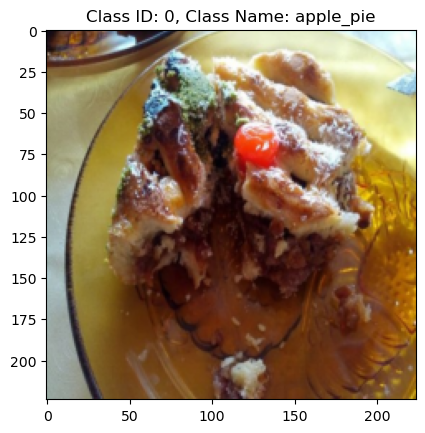

In [5]:
# Λειτουργία για να εμφανίζουμε τις εικόνες μαζί με το όνομα της κλάσης
def imshow_with_class(img, class_id, classes):
    class_name = list(classes.keys())[list(classes.values()).index(class_id)]
    plt.imshow(img.permute(1, 2, 0))  # Μετατροπή του tensor σε μορφή εικόνας (H, W, C)
    plt.title(f'Class ID: {class_id}, Class Name: {class_name}')
    plt.show()

# Λήψη ενός batch από τα δεδομένα εκπαίδευσης
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Εμφάνιση του πρώτου δείγματος από το batch
class_id = labels[0].item()
imshow_with_class(images[0], class_id, classes)

### 2.3 Βήμα 3 - Ορισμός Training Loop

Η συνάρτηση `train_model` εκπαιδεύει το μοντέλο για έναν συγκεκριμένο αριθμό εποχών, χρησιμοποιώντας έναν επιλεγμένο αλγόριθμο βελτιστοποίησης και ένα κριτήριο απώλειας. Κατά τη διάρκεια κάθε εποχής, υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης και αποθηκεύονται για να ελεγχθεί η απόδοση του μοντέλου. 

Η συνάρτηση `evaluate_model` χρησιμοποιείται για τον έλεγχο της απόδοσης του μοντέλου σε ένα σύνολο δεδομένων (είτε στο σύνολο επικύρωσης είτε στο σύνολο δοκιμής). Αυτή η συνάρτηση υπολογίζει την απώλεια και την ακρίβεια του μοντέλου.

In [38]:
# Ορίζουμε τη συσκευή εκτέλεσης (device) που θα χρησιμοποιήσουμε
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device to be used during training: {device}")

# Ορίζουμε τη συνάρτηση εκπαίδευσης
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    # Παράμετροι early stopping
    patience=5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Μετακινούμε το μοντέλο στη συσκευή εκτέλεσης
    model = model.to(device)

    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []

    metrics = {}
    
    # Ξεκινάμε την εκπαίδευση
    for epoch in range(num_epochs):
        # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        model.train()
        
        # Αρχικοποίηση των μετρικών
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Εκπαίδευση του μοντέλου σε κάθε batch
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            # Μηδενίζουμε τις καταχωρήσεις των gradients
            optimizer.zero_grad()
            
            # Προϋπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Αντίστροφη διάδοση του σφάλματος και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Εκτύπωση της απώλειας και της ακρίβειας στο σύνολο εκπαίδευσης
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
        # Αξιολόγηση του μοντέλου στο σύνολο επικύρωσης
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_accuracy)
        
        # Έλεγχος για πρόωρο τερματισμό αν δεν υπάρχει βελτίωση στο σύνολο επικύρωσης
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break
        
        # Αποθήκευση μετρικών
        metrics['train_loss'] = train_loss_hist
        metrics['train_acc'] = train_acc_hist
        metrics['val_loss'] = val_loss_hist
        metrics['val_acc'] = val_acc_hist
        
    print("Training completed.")
    
    return metrics

# Ορίζουμε τη συνάρτηση αξιολόγησης
def evaluate_model(model, data_loader, criterion):
    # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    model.eval()
    
    # Αρχικοποίηση των μετρικών
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Αξιολόγηση του μοντέλου στα δεδομένα
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Υπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Υπολογισμός της απώλειας και της ακρίβειας
    loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return loss, accuracy

Device to be used during training: cuda


### **1. Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας; Εξηγήστε.**


Η κράτηση ενός κομματιού του συνόλου εκπαίδευσης ως σύνολο επικύρωσης έχει ως στόχο την αξιολόγηση της γενικευτικής ικανότητας του μοντέλου. Το σύνολο επικύρωσης χρησιμεύει για την επίβλεψη της απόδοσης του μοντέλου κατά τη διάρκεια της εκπαίδευσης και της προσαρμογής των υπερπαραμέτρων του μοντέλου (όπως ο ρυθμός μάθησης) ώστε να αποφευχθεί το overfitting. Η χρήση ενός ξεχωριστού συνόλου επικύρωσης βοηθά στην αποφυγή του overfitting και στη βελτίωση της γενίκευσης του μοντέλου. Αν εκπαιδεύαμε το μοντέλο με όλα τα δεδομένα, θα υπήρχε ο κίνδυνος να είναι πολύ καλό στο σύνολο εκπαίδευσης αλλά να μην γενικεύει καλά σε νέα δεδομένα.

### **2. Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;**

Το πρόβλημα που καλούμαστε να λύσουμε στο συγκεκριμένο dataset είναι η αναγνώριση της κατηγορίας των τροφίμων από εικόνες. Αυτό είναι ένα πρόβλημα ταξινόμησης πολλαπλών κατηγοριών, όπου κάθε εικόνα μπορεί να ανήκει σε μία από πολλές διαφορετικές κατηγορίες τροφίμων. Για την εκπαίδευση ενός μοντέλου για ένα τέτοιο πρόβλημα, μια κατάλληλη συνάρτηση απώλειας είναι η κατηγορική απώλεια (categorical cross-entropy), η οποία είναι κατάλληλη για την αναγνώριση πολλαπλών κατηγοριών.

# Εκπαίδευση Συνελικτικών ∆ικτύων

Σε αυτό το βήμα εξετάζονται διάφορες αρχιτεκτονικές ΣΝΔ που να είναι ικάνα να λύσουν το πρόβλημα της κατηγοροποίησης των εικόνων

## 3.1 Εκπαίδευση

Ξεκινάμε με μια αρχιτεντονική μικρού δικτύου. Αυτό το δίκτυο έχει τα παρακάτω χαρακτηριστικά:


• Αλγόριθμο βελτιστοποίησης Adam με ρυθμό εκμάθησης 10<sup>4</sup>

• Εκτύπωση της απώλειας (loss), ορθότητας (accuracy) των υποσυνόλων εκπαίδευσης και επικύρωσης

• 30 εποχές μέγιστη διάρκεια εκπαίδευσης

• Πρόωρο τερματισμό της εκπαίδευσης (Early Stopping) αν δεν παρουσιαστεί μείωση της απώλειας στο
σύνολο επικύρωσης για 5 συνεχείς εποχές

In [7]:
import torch
import torch.nn as nn

class SmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SmallNet, self).__init__()
        # Πρώτο συνελικτικό επίπεδο: Είσοδος 3 καναλιών (RGB εικόνα), έξοδος 32 κανάλια, μέγεθος φίλτρου 3x3, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()  # Συνάρτηση ενεργοποίησης ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling με μέγεθος φίλτρου 2x2 και βήμα 2
        
        # Δεύτερο συνελικτικό επίπεδο: Είσοδος 32 κανάλια, έξοδος 64 κανάλια, μέγεθος φίλτρου 3x3, padding 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()  # Συνάρτηση ενεργοποίησης ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling με μέγεθος φίλτρου 2x2 και βήμα 2
        
        # Τρίτο συνελικτικό επίπεδο: Είσοδος 64 κανάλια, έξοδος 128 κανάλια, μέγεθος φίλτρου 3x3, padding 1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()  # Συνάρτηση ενεργοποίησης ReLU
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling με μέγεθος φίλτρου 2x2 και βήμα 2
        
        # Πλήρως συνδεδεμένο επίπεδο: Είσοδος 128*28*28 (ταξινομημένο output από το τελευταίο pooling επίπεδο), έξοδος num_classes (11)
        self.fc = nn.Linear(128 * 28 * 28, num_classes)
        
    def forward(self, x):
        # Πρώτο συνελικτικό μπλοκ
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Δεύτερο συνελικτικό μπλοκ
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Τρίτο συνελικτικό μπλοκ
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Ταξινόμηση των δεδομένων σε ένα διανύσμα 1D
        x = x.view(x.size(0), -1)  # Flatten
        
        # Πλήρως συνδεδεμένο επίπεδο για ταξινόμηση
        x = self.fc(x)
        
        return x

# Αρχικοποίηση του μοντέλου SmallNet
smallnet_model = SmallNet()


### Εκπαίδευση Συνελικτικών ∆ικτύων

In [8]:
# Δρημιουργία αντικειμένου ΣΝΔ
smallnet_model = SmallNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(smallnet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
smallnet_model_metrics = train_model(smallnet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:20<00:00,  6.09it/s]


Train Loss: 2.3036, Train Accuracy: 0.1765
Validation Loss: 2.1985, Validation Accuracy: 0.2323


Epoch 2/30: 100%|██████████| 124/124 [00:17<00:00,  6.91it/s]


Train Loss: 2.1069, Train Accuracy: 0.2801
Validation Loss: 2.0860, Validation Accuracy: 0.2899


Epoch 3/30: 100%|██████████| 124/124 [00:17<00:00,  6.97it/s]


Train Loss: 1.9566, Train Accuracy: 0.3389
Validation Loss: 2.0476, Validation Accuracy: 0.3146


Epoch 4/30: 100%|██████████| 124/124 [00:17<00:00,  6.93it/s]


Train Loss: 1.7978, Train Accuracy: 0.4062
Validation Loss: 1.9530, Validation Accuracy: 0.3419


Epoch 5/30: 100%|██████████| 124/124 [00:17<00:00,  7.01it/s]


Train Loss: 1.6397, Train Accuracy: 0.4676
Validation Loss: 1.9586, Validation Accuracy: 0.3439


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.88it/s]


Train Loss: 1.4982, Train Accuracy: 0.5144
Validation Loss: 2.0495, Validation Accuracy: 0.3263


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.84it/s]


Train Loss: 1.3269, Train Accuracy: 0.5768
Validation Loss: 1.9779, Validation Accuracy: 0.3530


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.85it/s]


Train Loss: 1.1307, Train Accuracy: 0.6452
Validation Loss: 2.1122, Validation Accuracy: 0.3374


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.86it/s]


Train Loss: 0.9783, Train Accuracy: 0.6972
Validation Loss: 2.1860, Validation Accuracy: 0.3505
No improvement for 5 epochs. Early stopping...
Training completed.


### Αξιολόγηση

In [9]:
# Helper function with Exponential Weighted Moving Average implementation for smoothing the lines
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

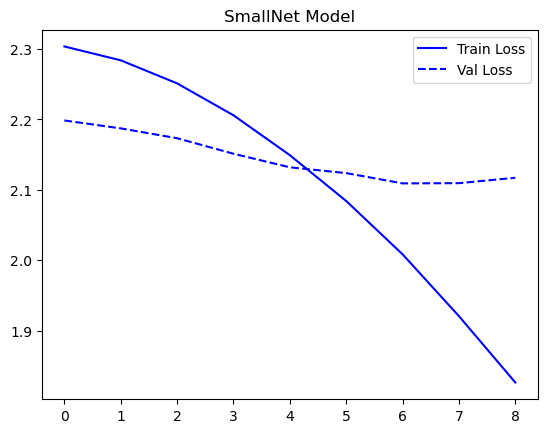

In [10]:
plt.plot(smooth(smallnet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(smallnet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('SmallNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Η απώλεια εκπαίδευσης γενικά μειώνεται με την πάροδο του χρόνου, γεγονός που υποδηλώνει ότι το μοντέλο μαθαίνει και βελτιώνει την απόδοσή του στα δεδομένα εκπαίδευσης. Η απώλεια επικύρωσης μειώνεται επίσης, γεγονός που υποδηλώνει ότι το μοντέλο γενικεύει καλά και δεν προσαρμόζεται υπερβολικά στα δεδομένα εκπαίδευσης.

 ## Συνελικτικό δίκτυο μεγάλου βάθους

Δημιουργείται ένα νεο ΣΝΔ μεγαλύτερου βάθους με τα εξής χαρακτηριστικά:

- Τρία συνελικτικά επίπεδα ακολουθούμενα από επίπεδα συγκέντρωσης (Max pooling) 
- Ένα πλήρως συνδεδεμένο επίπεδο στο τέλος.

In [11]:
import torch
import torch.nn as nn

class BigNet(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNet, self).__init__()
        # Ορίζουμε τα στρώματα του δικτύου
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()  # Συνάρτηση ενεργοποίησης ReLU
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Πλήρως συνδεδεμένα στρώματα
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Ορίζουμε τη ροή των δεδομένων μέσα από το δίκτυο
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [39]:
bignet_model = BigNet()

optimizer = optim.Adam(bignet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

bignet_model_metrics = train_model(bignet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30:  13%|█▎        | 16/124 [00:02<00:17,  6.32it/s]


KeyboardInterrupt: 

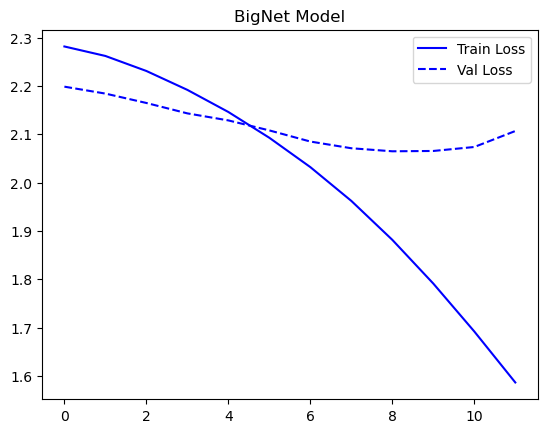

In [13]:
plt.plot(smooth(bignet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Παρατηρείται πως η επίδοση του μεγαλύτερου μοντέλου οδηγεί σε overfitting. Αυτό δίνει τη δυνατότητα στο δίκτυο να μάθει πολύπλοκα μοτίβα και ακόμα και θόρυβο στα δεδομένα εκπαίδευσης, κάτι που μπορεί να μη γενικεύει καλά σε νέα δεδομένα. 

Ο μεγάλος αριθμός επιπέδων και νευρώνων στο `BigNet` μοντέλο πιθανόν λόγω των περισσοτέρων παραμέτρους που έχει δεν είναι ικανό να γενικεύσει. Ιδίως στη περίπτωση που το μοντέλο δεν έχει κατάλληλη τεχνική ομαλοποίησης και ελέγχου χωρητικότητας.

Μια τεχνική ομαλοποίησης που μπορεί να χρησιμοποιηθεί είναι η απόσυρση (dropout). Η απόσυρση μπορεί να εφαρμοστεί μεταξύ των πλήρως συνδεδεμένων επιπέδων για να αποτρέψει την υπερ-προσαρμογή. Επιπλέον, μπορεί να χρησιμοποιηθεί η κανονικοποίηση βάρους (weight regularization), όπως η L2 κανονικοποίηση, για να ελέγξει το μέγεθος των βαρών του μοντέλου και να αποτρέψει την υπερ-προσαρμογή.

Έτσι, μπορούμε να δοκιμάσουμε τεχικές ομαλοποίησης σε αυτό για να δούμε εαν αυτές θα επιφέρουν αλλαγές στην επίδοση του ξεκινώντας απο το περιορισμό των τιμών που μπορούν να πάρουν τα βάρη του δικτύου. Αυτό ρυθμίζεται μεσα στον `optimizer` ως παράμετρος της σχετικής συνάρτησης (`weight_decay`).

In [14]:
bignet_model_v2 = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v2.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v2_metrics = train_model(bignet_model_v2, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.71it/s]


Train Loss: 2.2844, Train Accuracy: 0.1746
Validation Loss: 2.1805, Validation Accuracy: 0.2369


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s]


Train Loss: 2.1261, Train Accuracy: 0.2543
Validation Loss: 2.0946, Validation Accuracy: 0.2869


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 2.0191, Train Accuracy: 0.2975
Validation Loss: 2.0526, Validation Accuracy: 0.2874


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s]


Train Loss: 1.9298, Train Accuracy: 0.3356
Validation Loss: 2.0019, Validation Accuracy: 0.3167


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


Train Loss: 1.8292, Train Accuracy: 0.3846
Validation Loss: 1.9473, Validation Accuracy: 0.3359


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.61it/s]


Train Loss: 1.7383, Train Accuracy: 0.4154
Validation Loss: 1.9566, Validation Accuracy: 0.3313


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s]


Train Loss: 1.6620, Train Accuracy: 0.4453
Validation Loss: 1.9276, Validation Accuracy: 0.3510


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]


Train Loss: 1.5458, Train Accuracy: 0.4866
Validation Loss: 1.9003, Validation Accuracy: 0.3646


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.72it/s]


Train Loss: 1.4349, Train Accuracy: 0.5295
Validation Loss: 1.9665, Validation Accuracy: 0.3500


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 1.3275, Train Accuracy: 0.5597
Validation Loss: 1.9634, Validation Accuracy: 0.3495


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.61it/s]


Train Loss: 1.1677, Train Accuracy: 0.6193
Validation Loss: 2.0021, Validation Accuracy: 0.3586


Epoch 12/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 1.0372, Train Accuracy: 0.6681
Validation Loss: 2.1076, Validation Accuracy: 0.3621


Epoch 13/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 0.8454, Train Accuracy: 0.7337
Validation Loss: 2.2387, Validation Accuracy: 0.3535
No improvement for 5 epochs. Early stopping...
Training completed.


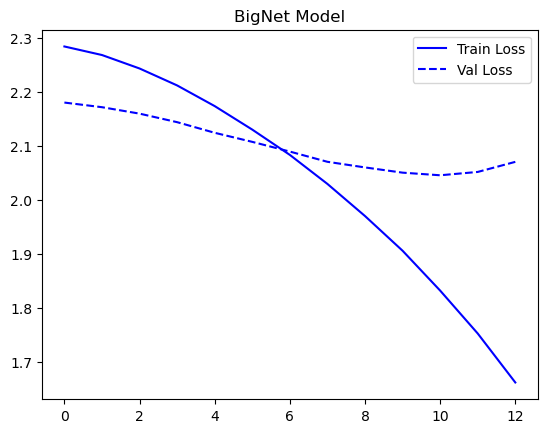

In [15]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v2_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v2_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Τα αποτελέσματα δε προσδίδουν κάποια εμφανή αλλαγή. Έτσι, επιστρατεύεται η τεχνική ομαλοποίησης "Dropout" η οποία αποκόπτει τυχαία μερίδα νευρώνων με κάποια πιθανότητα p από κάθε επίπεδο του δικτύου κατά τη διάρκεια κάθε εποχής εκπαίδευσης.

Αυτό έχει ως αποτέλεσμα το δίκτυο να μην μπορεί να βασιστεί υπερβολικά σε συγκεκριμένους νευρώνες και να αναπτύσσει πιο γενικευμένα χαρακτηριστικά.

Προστίθεται έτσι ενα επίπεδο Dropout μετά απο επίπδα συνέλιξης με πιθανότητα 0.5

In [16]:
class BigNetDropout(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNetDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Ορίζουμε την πιθανότητα dropout (εδώ 0.5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο max pooling layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο max pooling layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το τρίτο max pooling layer
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο fully connected layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο fully connected layer
        x = self.fc3(x)
        return x


In [17]:
# Dropout Net
bignet_model_v3 = BigNetDropout()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v3.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v3_metrics = train_model(bignet_model_v3, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]


Train Loss: 2.4054, Train Accuracy: 0.0957
Validation Loss: 2.3968, Validation Accuracy: 0.0949


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 2.3709, Train Accuracy: 0.1159
Validation Loss: 2.3540, Validation Accuracy: 0.1515


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 2.3061, Train Accuracy: 0.1616
Validation Loss: 2.3235, Validation Accuracy: 0.1601


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 2.2651, Train Accuracy: 0.1775
Validation Loss: 2.3140, Validation Accuracy: 0.1753


Epoch 5/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 2.2315, Train Accuracy: 0.1956
Validation Loss: 2.2840, Validation Accuracy: 0.1889


Epoch 6/30: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s]


Train Loss: 2.1962, Train Accuracy: 0.2160
Validation Loss: 2.2461, Validation Accuracy: 0.2182


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 2.1624, Train Accuracy: 0.2386
Validation Loss: 2.2177, Validation Accuracy: 0.2434


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 2.1352, Train Accuracy: 0.2473
Validation Loss: 2.1741, Validation Accuracy: 0.2505


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 2.1042, Train Accuracy: 0.2664
Validation Loss: 2.1679, Validation Accuracy: 0.2641


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 2.0760, Train Accuracy: 0.2761
Validation Loss: 2.1345, Validation Accuracy: 0.2732


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 2.0505, Train Accuracy: 0.2867
Validation Loss: 2.1131, Validation Accuracy: 0.2818


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.68it/s]


Train Loss: 2.0274, Train Accuracy: 0.2995
Validation Loss: 2.1148, Validation Accuracy: 0.2778


Epoch 13/30: 100%|██████████| 124/124 [00:18<00:00,  6.63it/s]


Train Loss: 2.0092, Train Accuracy: 0.3057
Validation Loss: 2.1105, Validation Accuracy: 0.2939


Epoch 14/30: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Train Loss: 1.9864, Train Accuracy: 0.3144
Validation Loss: 2.0947, Validation Accuracy: 0.2753


Epoch 15/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 1.9580, Train Accuracy: 0.3314
Validation Loss: 2.0564, Validation Accuracy: 0.2990


Epoch 16/30: 100%|██████████| 124/124 [00:19<00:00,  6.39it/s]


Train Loss: 1.9154, Train Accuracy: 0.3429
Validation Loss: 2.0672, Validation Accuracy: 0.2833


Epoch 17/30: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]


Train Loss: 1.8974, Train Accuracy: 0.3540
Validation Loss: 2.0322, Validation Accuracy: 0.2985


Epoch 18/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 1.8618, Train Accuracy: 0.3696
Validation Loss: 2.0465, Validation Accuracy: 0.2929


Epoch 19/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.8239, Train Accuracy: 0.3795
Validation Loss: 2.0444, Validation Accuracy: 0.2939


Epoch 20/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 1.7932, Train Accuracy: 0.3924
Validation Loss: 2.0277, Validation Accuracy: 0.3111


Epoch 21/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.7633, Train Accuracy: 0.4010
Validation Loss: 2.0399, Validation Accuracy: 0.2889


Epoch 22/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 1.7182, Train Accuracy: 0.4104
Validation Loss: 2.0035, Validation Accuracy: 0.3136


Epoch 23/30: 100%|██████████| 124/124 [00:18<00:00,  6.57it/s]


Train Loss: 1.6739, Train Accuracy: 0.4323
Validation Loss: 1.9935, Validation Accuracy: 0.3202


Epoch 24/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 1.6233, Train Accuracy: 0.4553
Validation Loss: 2.0075, Validation Accuracy: 0.3197


Epoch 25/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 1.5744, Train Accuracy: 0.4654
Validation Loss: 1.9559, Validation Accuracy: 0.3343


Epoch 26/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.5339, Train Accuracy: 0.4857
Validation Loss: 1.9974, Validation Accuracy: 0.3253


Epoch 27/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 1.4735, Train Accuracy: 0.5129
Validation Loss: 2.0017, Validation Accuracy: 0.3076


Epoch 28/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.4368, Train Accuracy: 0.5109
Validation Loss: 1.9791, Validation Accuracy: 0.3278


Epoch 29/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.3705, Train Accuracy: 0.5394
Validation Loss: 2.0018, Validation Accuracy: 0.3227


Epoch 30/30: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s]


Train Loss: 1.3167, Train Accuracy: 0.5543
Validation Loss: 2.0582, Validation Accuracy: 0.3101
No improvement for 5 epochs. Early stopping...
Training completed.


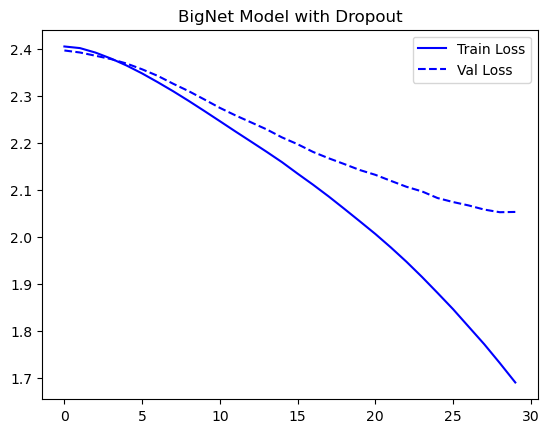

In [18]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v3_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v3_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model with Dropout')
plt.legend(['Train Loss', 'Val Loss'])

Η τεχνική Dropout φαίνεται να βοήθησε αρκετά καθότι πλέον το μοντέλο δείχνει να μπορεί να γενικεύει ωστόσο όχι σε ικανοποιητικό βαθμό.

## Προεκπαιδευμένο Νευρωνικό ∆ίκτυο (ResNet 50)

In [19]:
# Επιλέγουμε τα βάρη του ResNet-50 που έχουν προεκπαιδευτεί στο σύνολο δεδομένων ImageNet
weights = ResNet50_Weights.IMAGENET1K_V2

# Αρχικοποιούμε το μοντέλο ResNet-50 με τα προεκπαιδευμένα βάρη
resnet50_model = resnet50(weights=weights)

# Ορίζουμε τον αριθμό των κλάσεων για το νέο σύνολο δεδομένων μας
num_classes = 11

# Λαμβάνουμε τον αριθμό των εισόδων στο τελευταίο πλήρως συνδεδεμένο επίπεδο (fully connected layer) του ResNet-50
num_features = resnet50_model.fc.in_features

# Δημιουργούμε ένα νέο πλήρως συνδεδεμένο επίπεδο με τον σωστό αριθμό εξόδων για τις νέες κλάσεις
new_fc = nn.Linear(num_features, num_classes)

# Αντικαθιστούμε το τελευταίο πλήρως συνδεδεμένο επίπεδο του ResNet-50 με το νέο μας επίπεδο
resnet50_model.fc = new_fc

In [20]:
# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
resnet50_model_metrics = train_model(resnet50_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:31<00:00,  3.98it/s]


Train Loss: 1.0650, Train Accuracy: 0.7115
Validation Loss: 0.4170, Validation Accuracy: 0.8773


Epoch 2/30: 100%|██████████| 124/124 [00:31<00:00,  4.00it/s]


Train Loss: 0.2288, Train Accuracy: 0.9316
Validation Loss: 0.3669, Validation Accuracy: 0.8838


Epoch 3/30: 100%|██████████| 124/124 [00:31<00:00,  3.99it/s]


Train Loss: 0.0808, Train Accuracy: 0.9782
Validation Loss: 0.3710, Validation Accuracy: 0.8884


Epoch 4/30: 100%|██████████| 124/124 [00:31<00:00,  3.99it/s]


Train Loss: 0.0405, Train Accuracy: 0.9896
Validation Loss: 0.4170, Validation Accuracy: 0.8894


Epoch 5/30: 100%|██████████| 124/124 [00:31<00:00,  3.97it/s]


Train Loss: 0.0244, Train Accuracy: 0.9947
Validation Loss: 0.4074, Validation Accuracy: 0.8965


Epoch 6/30: 100%|██████████| 124/124 [00:31<00:00,  3.98it/s]


Train Loss: 0.0275, Train Accuracy: 0.9927
Validation Loss: 0.4251, Validation Accuracy: 0.8904


Epoch 7/30: 100%|██████████| 124/124 [00:31<00:00,  3.98it/s]


Train Loss: 0.0257, Train Accuracy: 0.9924
Validation Loss: 0.5440, Validation Accuracy: 0.8652
No improvement for 5 epochs. Early stopping...
Training completed.


<class 'torchvision.models.resnet.ResNet'>


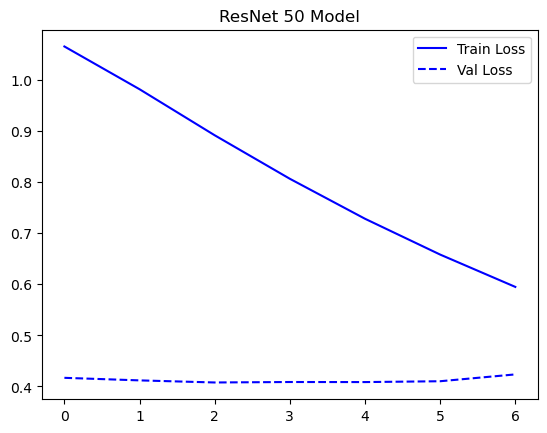

In [21]:
plt.plot(smooth(resnet50_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(resnet50_model_metrics['val_loss'], 0.9), 'b--')
plt.title('ResNet 50 Model')
plt.legend(['Train Loss', 'Val Loss'])

print(type(resnet50_model))

## Προεκπαιδευμένο Νευρωνικό ∆ίκτυο (ViT)

Οι Visual Transformers (ViTs) έχουν αποδειχθεί ότι είναι καλύτεροι από τα μοντέλα ResNet σε προβλήματα ταξινόμησης εικόνων για διάφορους λόγους. Πρώτον, οι ViTs χρησιμοποιούν τον μηχανισμό αυτοπροσοχής (self-attention), που τους επιτρέπει να μοντελοποιούν μακρινές σχέσεις μέσα στην εικόνα. Αυτό σημαίνει ότι μπορούν να εντοπίζουν συσχετίσεις μεταξύ απομακρυσμένων περιοχών της εικόνας πιο αποτελεσματικά από τα CNNs, όπως τα ResNets.

Επιπλέον, οι ViTs επωφελούνται περισσότερο από την αύξηση των δεδομένων και της υπολογιστικής ισχύος. Ενώ τα ResNets αρχίζουν να παρουσιάζουν φθίνουσες αποδόσεις καθώς αυξάνεται το μέγεθος του μοντέλου όπως και παρατηρήθηκε απο τα παραπάνω, οι ViTs συνεχίζουν να βελτιώνονται, εκμεταλλευόμενοι το μέγεθος των δεδομένων και την ικανότητα επεξεργασίας.

Οι ViTs έχουν πιο απλή αρχιτεκτονική σε σύγκριση με τα CNNs, αφού δεν χρησιμοποιούν πολύπλοκες λειτουργίες όπως τα φίλτρα συνελικτικής (convolutional filters). Αυτό σημαίνει ότι είναι πιο εύκολο να κλιμακωθούν και να προσαρμοστούν σε διαφορετικά μεγέθη και τύπους δεδομένων. Επίσης, οι ViTs μπορούν να μάθουν πιο πολύπλοκα χαρακτηριστικά από τις εικόνες λόγω της δυνατότητας να αντιλαμβάνονται πιο περίπλοκα πρότυπα και σχέσεις μεταξύ των pixel. Αυτό τους δίνει ένα πλεονέκτημα σε σύνθετα σύνολα δεδομένων.

Οι ViTs έχουν δείξει εξαιρετική απόδοση σε μεταφορά μάθησης, δηλαδή όταν ένα προεκπαιδευμένο μοντέλο προσαρμόζεται σε νέο, διαφορετικό σύνολο δεδομένων. Αυτό τους καθιστά πολύ ευέλικτους για χρήση σε διάφορα είδη προβλημάτων ταξινόμησης εικόνων.

Συνεπώς, επιλέχθηκε η χρήση των ViT μοντέλων εφόσον αυτά παρέχονται με τον ίδιο τρόπο μεσω του PyTorch και τα αποτελέσματα είναι αρκετά ικανοποιητικά όπως φαίνεται και στο BONUS ερώτημα όπου έγινε χρήση νέων φωτογραφιών και ανιχνεύονται σωστά απο το εκπαιδευόμενο μοντέλο.

In [22]:
# Επιλέγουμε τα βάρη του ViT που έχουν προεκπαιδευτεί στο σύνολο δεδομένων ImageNet
weights = ViT_B_16_Weights.IMAGENET1K_V1

# Αρχικοποιούμε το μοντέλο ViT-B/16 με τα προεκπαιδευμένα βάρη
vit_model = vit_b_16(weights=weights)

# Ορίζουμε τον αριθμό των κλάσεων για το νέο σύνολο δεδομένων μας
num_classes = 11

# Λαμβάνουμε τον αριθμό των εισόδων στο τελευταίο πλήρως συνδεδεμένο επίπεδο (fully connected layer) του ViT
num_features = vit_model.heads.head.in_features

# Δημιουργούμε ένα νέο πλήρως συνδεδεμένο επίπεδο με τον σωστό αριθμό εξόδων για τις νέες κλάσεις
new_fc = nn.Linear(num_features, num_classes)

# Αντικαθιστούμε το τελευταίο πλήρως συνδεδεμένο επίπεδο του ViT με το νέο μας επίπεδο
vit_model.heads.head = new_fc

In [34]:
# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
vit_model_metrics = train_model(vit_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [01:14<00:00,  1.67it/s]


Train Loss: 0.0920, Train Accuracy: 0.9721
Validation Loss: 0.5307, Validation Accuracy: 0.8646


Epoch 2/30: 100%|██████████| 124/124 [01:14<00:00,  1.67it/s]


Train Loss: 0.0815, Train Accuracy: 0.9745
Validation Loss: 0.5456, Validation Accuracy: 0.8646


Epoch 3/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0967, Train Accuracy: 0.9692
Validation Loss: 0.6287, Validation Accuracy: 0.8475


Epoch 4/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0500, Train Accuracy: 0.9830
Validation Loss: 0.7531, Validation Accuracy: 0.8273


Epoch 5/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0835, Train Accuracy: 0.9737
Validation Loss: 0.6332, Validation Accuracy: 0.8369


Epoch 6/30: 100%|██████████| 124/124 [01:15<00:00,  1.65it/s]


Train Loss: 0.0802, Train Accuracy: 0.9747
Validation Loss: 0.7368, Validation Accuracy: 0.8197
No improvement for 5 epochs. Early stopping...
Training completed.


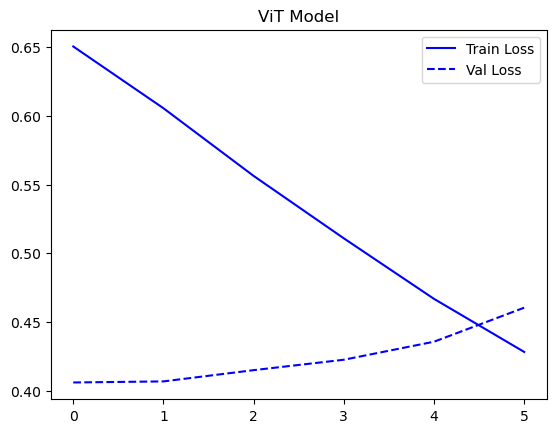

In [24]:
plt.plot(smooth(vit_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(vit_model_metrics['val_loss'], 0.9), 'b--')
plt.title('ViT Model')
plt.legend(['Train Loss', 'Val Loss'])

In [25]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                row = images_so_far // 3
                col = images_so_far % 3
                ax = axes[row, col]
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                # ax.set_title(f'predicted: ')
                ax.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

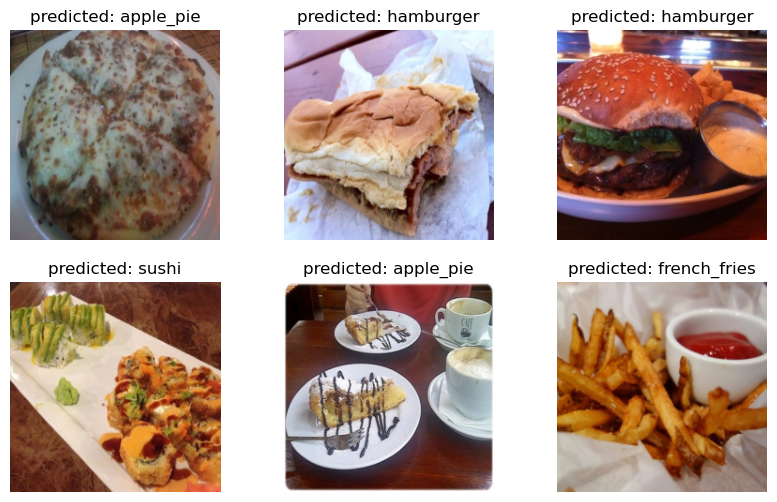

In [26]:
classes_names_list = list(classes.keys())

visualize_model(vit_model, val_loader, classes_names_list)

# BONUS

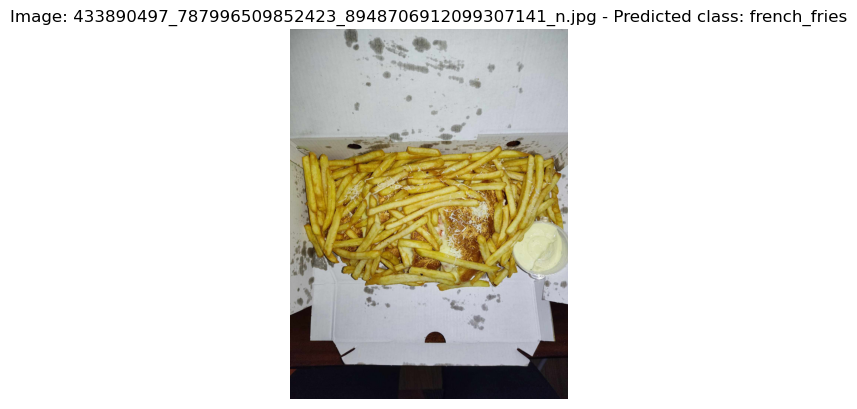

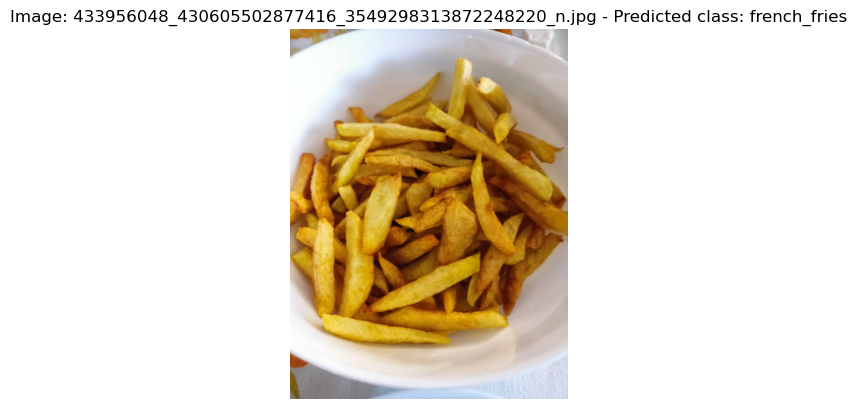

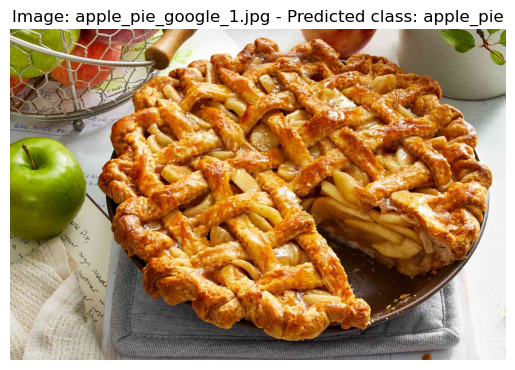

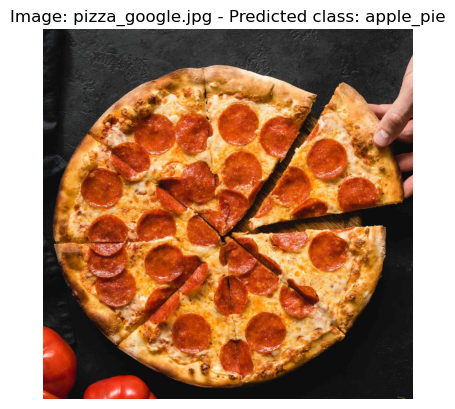

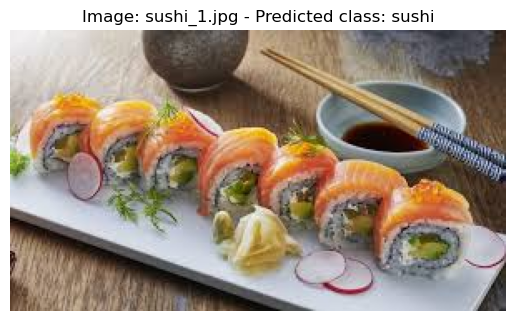

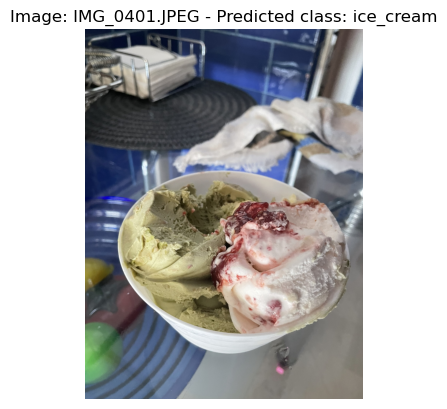

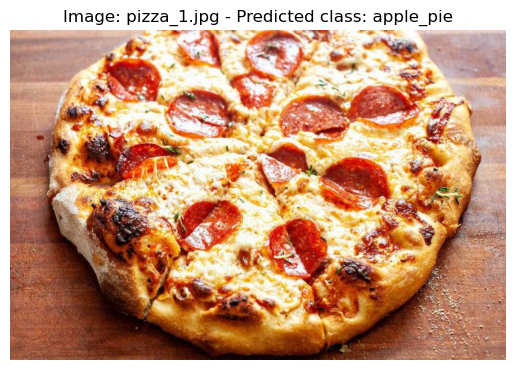

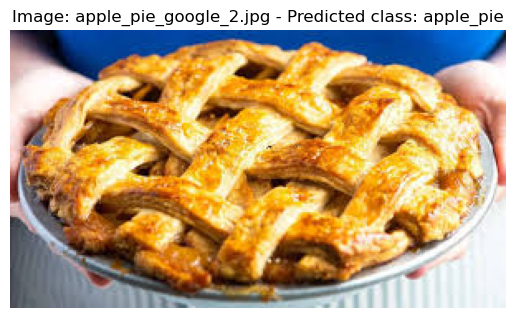

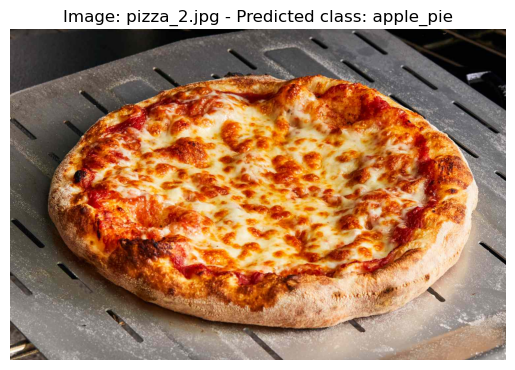

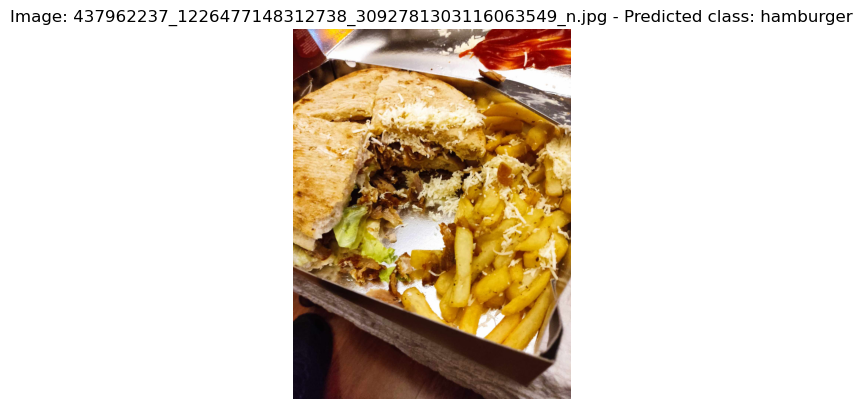

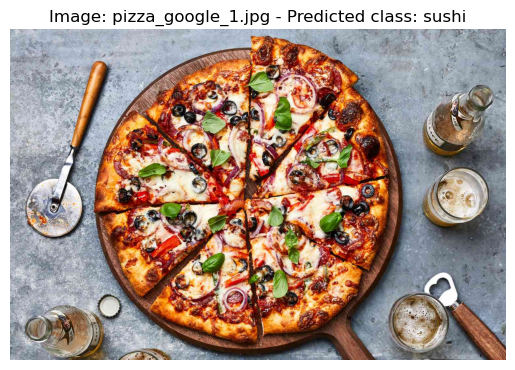

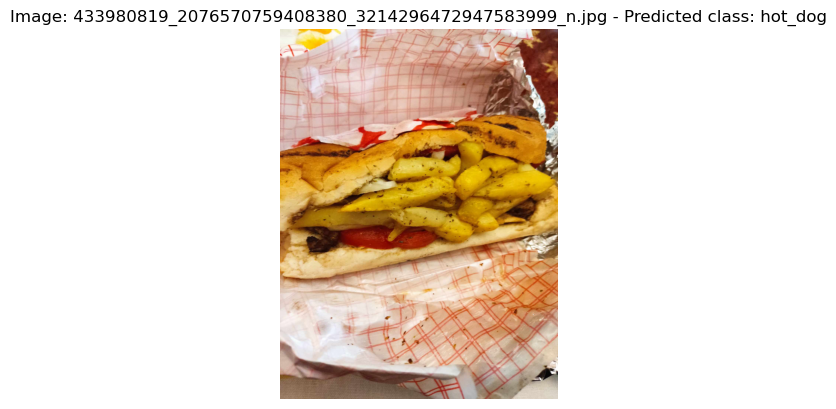

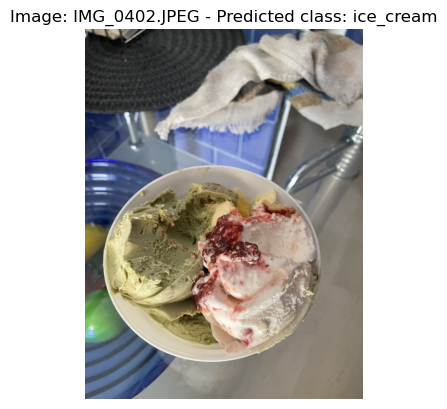

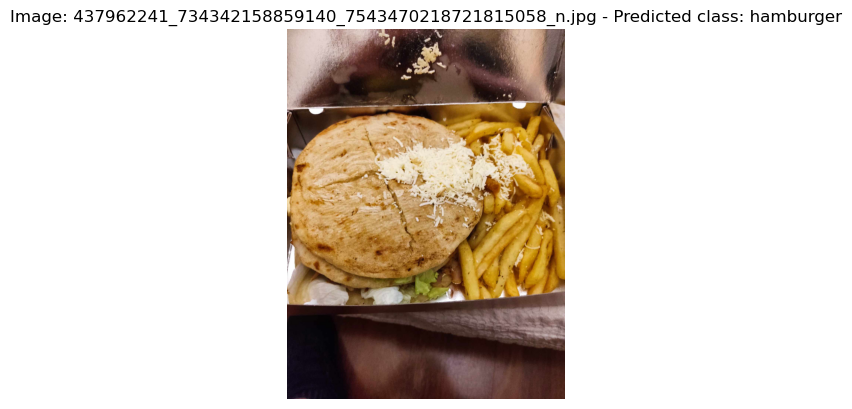

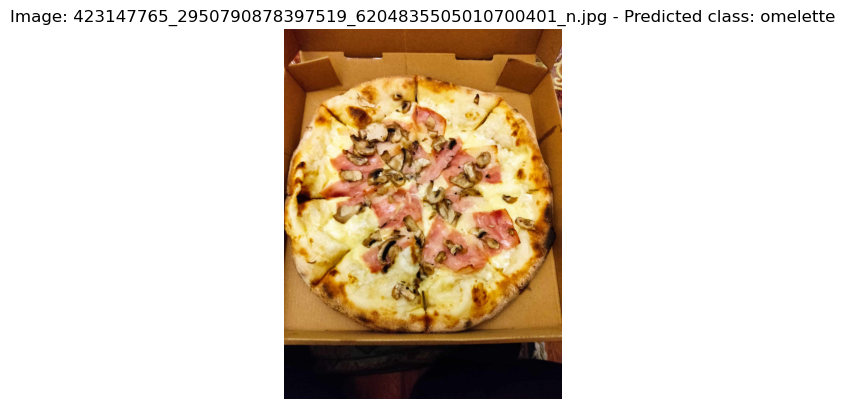

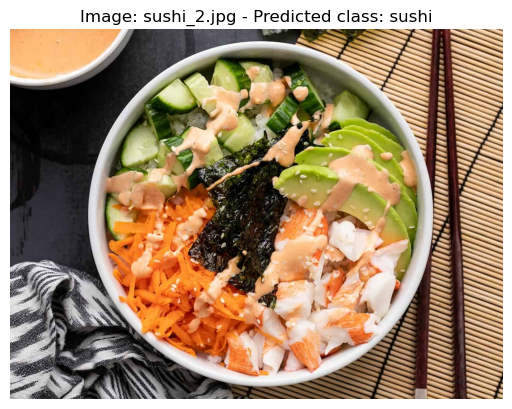

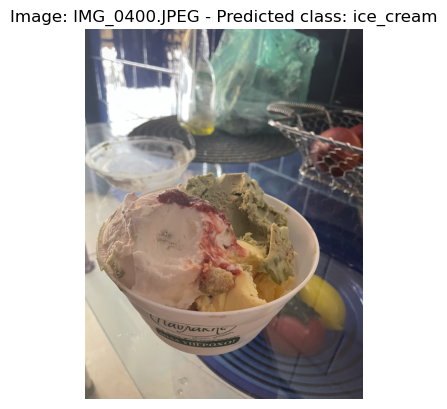

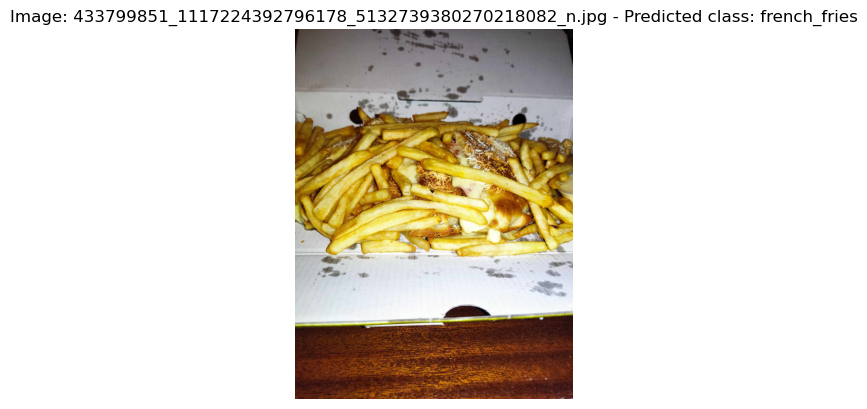

In [33]:
custom_images_path = "my_data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vit_model

# List all files in the directory
custom_images = os.listdir(custom_images_path)
custom_images = [entry for entry in custom_images if '.' in entry and not entry.startswith('.')]

# Loop through custom images and plot them individually
for custom_image in custom_images:
    image = Image.open(os.path.join(custom_images_path, custom_image))
    
    model.to(device)
    # Ensure the model is in evaluation mode before passing the image.
    model.eval()
    
    # Convert the custom image to tensor and move it to the appropriate device.
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    custom_image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(custom_image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class label
    predicted_class = classes_names_list[predicted.item()]
    
    # Plot the image with the predicted class title
    plt.imshow(image)
    plt.title(f'Image: {custom_image} - Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()